# control estimation of attraction in the presence of diffusion
Tim Tyree<br>
11.2.2021

In [1]:
import cupy as cp, numpy as np
import time
import matplotlib.pyplot as plt
from lib import *
from scipy.signal import savgol_filter
import dask.bag as db

In [2]:
darkmode=True
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [3]:
seed=42
# #random number stream A
# rs = RandomState(MT19937(SeedSequence(seed)))
# #random number stream B
# # rs = RandomState(MT19937(SeedSequence(987654321)))
np.random.seed(seed)
# cp.random.seed(seed)

# define module

In [4]:
def gener_positions_control(
    num_pairs=1500, #number of independent pairs of particles
    a=5, #cm^2/s known attraction coefficient 
    D=1, #cm^2/s known diffusion coefficient
    Dt=1e-5,
    print_every=100000,
    rend=0.1, #cm
    printing=False,**kwargs
):
    '''
    Example Usage:
    positions_out,mean_array,std_array=gener_positions_control(a=a,D=D,printing=True)
    '''
    #initialize particles locations as being at the same locations
    t=0
    x1=0
    x2=0.5
    y1=0
    y2=0.5
    zero_values=np.zeros(num_pairs)

    x1_values=zero_values.copy()+x1
    x2_values=zero_values.copy()+x2
    y1_values=zero_values.copy()+y1
    y2_values=zero_values.copy()+y2

    stepscale = np.sqrt(2 * D * Dt)
    impulse_prefactor = a * Dt

    tmax=10#0.1#1 #seconds
    num_steps=np.int64(np.around(tmax/Dt))

    position_array=np.zeros(shape=(num_steps,4,num_pairs))+np.nan
    mean_array=np.zeros(shape=(num_steps,3))
    std_array=np.zeros(shape=(num_steps,3))

    #GOAL: add support for still_running

    boo_still_running=zero_values==zero_values
    #TODO: initiallize still_running to True
    #TODO: compute boo where particles become smaller than R_

    #compute the distance between each pair of particles
    dx_values=(x2_values-x1_values)
    dy_values=(y2_values-y1_values)
    Rsq_values=dx_values*dx_values+dy_values*dy_values

    if printing:
        print(f"running simulation for {num_steps} steps...")
    start=time.time()
    for step_num in range(num_steps):
        #compute the attractive step between all pairs
        f_values=impulse_prefactor/Rsq_values
        F1x=f_values*dx_values
        F1y=f_values*dy_values

        #compute the diffusive step between all pairs
        dxW1_values=stepscale*np.random.normal(size=num_pairs)
        dxW2_values=stepscale*np.random.normal(size=num_pairs)
        dyW1_values=stepscale*np.random.normal(size=num_pairs)
        dyW2_values=stepscale*np.random.normal(size=num_pairs)

        #the mean distance between all pairs of particles
        R_values=np.sqrt(Rsq_values)
        mean_R=np.mean(R_values)
        std_R=np.mean(R_values)

        #the mean magnitude of the diffusive step
        diffusive_step_values=0.5*np.sqrt(dxW1_values**2+dyW1_values**2)+0.5*np.sqrt(dxW2_values**2+dyW2_values**2)
        mean_diffusive_step=np.mean(diffusive_step_values)
        std_diffusive_step=np.std(diffusive_step_values)

        #the mean magnitude of the attractive step
        attractive_step_values=np.sqrt(F1x**2+F1y**2)
        mean_attractive_step=np.mean(attractive_step_values)
        std_attractive_step=np.std(attractive_step_values)
        if printing:
            if (step_num+1) % print_every == 0:
                relative_percent=100*mean_diffusive_step/mean_attractive_step
                print(f"simulation {100*(step_num+1)/num_steps:.0f}% completed: R={mean_R:.4f}+/-{1.96*std_R:.4f}, diffusion/attraction is {relative_percent:.2f}%")
                # print(f"the mean range is {mean_R:.4f} cm")
                # print(f"the mean diffusive step was {100*mean_diffusive_step/mean_attractive_step:.2f}% larger than the mean attractive step")

        #compute the net change in position 
        x1step_values=F1x+dxW1_values
        y1step_values=F1y+dyW1_values
        x2step_values=-F1x+dxW2_values
        y2step_values=-F1y+dyW2_values

        #identify any particles that didn't get within the threshold distance
        #compute the distance between each pair of particles
        dx_values=(x2_values-x1_values)
        dy_values=(y2_values-y1_values)
        Rsq_values=dx_values*dx_values+dy_values*dy_values

        #update particle locations if they are still running
        x1_values[boo_still_running]=x1_values[boo_still_running]+x1step_values[boo_still_running]
        y1_values[boo_still_running]=y1_values[boo_still_running]+y1step_values[boo_still_running]
        x2_values[boo_still_running]=x2_values[boo_still_running]+x2step_values[boo_still_running]
        y2_values[boo_still_running]=y2_values[boo_still_running]+y2step_values[boo_still_running]
        #DONE: verified the mean distance between particles got smaller    
        # if (step_count+1) % save_every == 0:
        #save particle locations to a numpy array with the correct number of positions
        # x1,y1,x2,y2
        position_array[step_num,0,boo_still_running]=x1_values[boo_still_running]
        position_array[step_num,1,boo_still_running]=y1_values[boo_still_running]
        position_array[step_num,2,boo_still_running]=x2_values[boo_still_running]
        position_array[step_num,3,boo_still_running]=y2_values[boo_still_running]
        mean_array[step_num,0]=mean_R
        mean_array[step_num,1]=mean_diffusive_step
        mean_array[step_num,2]=mean_attractive_step
        #save results for quick plotting
        std_array[step_num,0]=std_R
        std_array[step_num,1]=std_diffusive_step
        std_array[step_num,2]=std_attractive_step

    #         #identify any particles that didn't get within the threshold distance
    #         #compute the distance between each pair of particles
    #         dx_values=(x2_values-x1_values)
    #         dy_values=(y2_values-y1_values)
    #         Rsq_values=dx_values*dx_values+dy_values*dy_values
        R_values=np.sqrt(Rsq_values)
        boo_still_running=boo_still_running&(R_values>rend)

    if printing:
        print(f"simulation complete!\nTotal run time: {time.time()-start:.4f} seconds")
        print(f"the number of particles that didn't finished is {sum(boo_still_running)} out of {boo_still_running.shape[0]}.")

    #DONE: compute the apparent attraction coefficient without smoothing
    # np.argwhere(np.isnan(position_array[:,0,i])).flatten()
    #identify any pairs that didn't end up closer than rend
    boo_didnt_finish=~np.isnan(position_array[-1,0,:])
    pairs_didnt_finish=np.argwhere(boo_didnt_finish).flatten()
    #     if printing:
    #         print((boo_didnt_finish.shape,pairs_didnt_finish))
    set_pairs_ignore=set(pairs_didnt_finish)

    tmax_recall=0.055 #max time to recall before the value is not nan
    num_rows_recall=np.int64(np.around(tmax_recall/Dt))
    if printing:
        print(num_rows_recall)

    #for each pair, identify the last row where the value is not nan
    row_end_values=zero_values.copy()+np.nan
    for i in range(num_pairs):
        if not set_pairs_ignore.issuperset({i}):
            row_end=np.int64(np.argwhere(np.isnan(position_array[:,0,i]))[0,0])-1
            row_end_values[i]=row_end
    #         #this step can introduce some error
    #         if row_end<num_rows_recall:
    #             #add this i to the ignore list
    #             set_pairs_ignore.add(i)

    #DONE: add pair to set_pairs_ignore if it ends sooner than num_rows_recall

    #for each pair not to be ignored, put the last num_rows_recall before row_end_values into an array
    positions_lst=[]
    for i in range(num_pairs):
        if not set_pairs_ignore.issuperset({i}):
            row_end=np.int64(row_end_values[i])
            if row_end>=num_rows_recall:
                positions=position_array[row_end-num_rows_recall:row_end,:,i]
            else:
                num_rows_rec=row_end
                num_rows_pad=num_rows_recall-row_end
                #pad the start with nans
                nan_pad=np.full([num_rows_pad,4], np.nan)
                positions=position_array[row_end-num_rows_rec:row_end,:,i]
                #pad positions at its front
                positions=np.concatenate((nan_pad,positions))

            positions_lst.append(positions)
    positions_out=np.stack(positions_lst,axis=-1)
    del position_array
    del positions_lst
    return positions_out,mean_array,std_array

Recall that it can be shown that
    $$
    dW(s')dW(s)=s\delta_{ss'};\; \int_0^tWdW(s)=\frac{1}{2}W(t)^2-\frac{1}{2}t^2
    $$

__Lemma__
$$
\int_0^tdW(s)[W(s)]_\alpha=\frac{1}{2}W^2(t)+(\alpha-\frac{1}{2})t
$$

__Result__
The slope of the mean squared range until collision can be used to estimate the attraction coeffiecient in the presence of diffusion.

__Proof__

Let 
$$
dR=-\frac{2a}{R}dt + CdW.
$$
Then, 

$$\begin{eqnarray}
\mathbb{E}[R^2(t)] &=& \mathbb{E}[\int_0^tdR^2(s)] \\
&=& \int_0^t\mathbb{E}[2RdR(s)] \qquad \text{product rule}\\
&=& \int_0^t\mathbb{E}[2R(-\frac{2a}{R}ds + CdW(s))] + R_0^2 \qquad \text{substitution} \\
&=& 2\int_0^t(-2ads)+2C\int_0^t \mathbb{E}[RdW(s)] + R_0^2 \qquad \text{linearity} \\
&=& -4at+2C\int_0^t\mathbb{E}\big[\big(R_0+\int_0^s-\frac{2a}{R}ds' + \int_0^sCdW(s')\big)dW(s)\big] + R_0^2 \qquad \text{substitution} \\
&=& -4at+2C^2\int_0^t \mathbb{E}[\int_0^s dW(s')dW(s)] + R_0^2 \\
&=& -4at+2C^2\mathbb{E}[\int_0^t W(s)dW(s)] + R_0^2 \\
&=& -4at+2C^2\mathbb{E}[\int_0^t dW(s)[W(s)]_\alpha] + R_0^2 \qquad \text{choose discretization } \alpha\in[0,1) \\
&=& -4at+2C^2\mathbb{E}[\frac{1}{2}W^2(t)+(\alpha-\frac{1}{2})t] + R_0^2 \\
&=& -4at+C^2(t+2\alpha t - t) + R_0^2 \\
&=& -4at+2C^2\alpha t + R_0^2 \\
&=& -4(a-\frac{1}{2}\alpha C^2)t + R_0^2 \\
&\equiv& -4\hat{a}t + R_0^2 \\
&\equiv& 4\hat{a}(t_f-t) \\
\end{eqnarray}$$


For $\alpha=0$ (It$\hat{o}$), we have $\hat{a}=a$.

For $\alpha=1/2$ (Stratonivich) and for $C=\sqrt{8D}$, we have 

$$
a=\hat{a}-\frac{1}{2}\alpha C^2 =\hat{a}-2D
$$

Equivalently,

$$
\hat{a}=a+2D
$$

This suggests that (in the Stratovinich picture, we would expect the apparent attraction coefficient $\hat{a}$ estimated by ordinary least squares to be larger than the ground truth attraction coefficient, $a$, by an amount $D$.

In [5]:
22000/5500

4.0

In [6]:
# for p in positions_lst:
#     print(len(p))

In [7]:
# #TODO: solve the array length disagreement in positions_lst
# D

In [8]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float,axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [9]:
def compute_attraction_coefficient_results(positions_out,tavg1,tavg2,Dt,printing=False,**kwargs):
    '''
    Example Usage:
    df=compute_attraction_coefficient_results(positions_out,tavg1,tavg2,Dt)
    '''
    navg1=np.int64(np.around(tavg1/(Dt*10**3)))
    navg2=np.int64(np.around(tavg2/(Dt*10**3)))

    #define time points
    #i=0
    num_timepoints=positions_out.shape[0]
    t_values=np.arange(0,Dt*num_timepoints,Dt)
    #assert t_values.shape==range_values[:,i].shape
    
    #moving avg
    if tavg1>0:
        #compute the moving average of the positional trajectories
        tavg_values=moving_average(t_values,n=navg1)
        positions_out_ma=moving_average(positions_out, n=navg1)
    else:
        tavg_values=t_values
        positions_out_ma=positions_out

    #compute range # x1,y1,x2,y2
    range_values= np.sqrt((positions_out_ma[:,0,:]-positions_out_ma[:,2,:])**2 + (positions_out_ma[:,1,:]-positions_out_ma[:,3,:])**2)


    R_savgol_values=range_values.copy()
    #compute savgol filter
    if navg2>0:
        if navg2<30: navg2=30
        if navg2%2==0:navg2+=1
        #DONE: test whether there is a significant difference between the savgol derivative and the finite difference derivative of the savgol filter
        savgol_kwargs = dict(window_length=navg2,polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
        #compute the savgol_filtered values for R
        for i in range(range_values.shape[1]):
            R_savgol_values[:,i]=savgol_filter(range_values[:,i],**savgol_kwargs)
        SR_values=R_savgol_values**2
    else:
        SR_values=range_values**2

    #DONE: sompute MSR_values from SR_values
    # SR_values

#     if printing:
#         print('nota bene: nan values are being kept in positions_out, so care needs to be taken to compute the particle averaged SR for every time')
#         print(f"HINT: I need to compute the nonnan boolean index for each time slice")
    #np.isnan(SR_values).any(),SR_values.shape
    # assert not np.isnan(positions_out).any()

    # the nonnan boolean index for each time slice
    MSR_values=np.zeros_like(SR_values[:,0])
    num_tbin,num_trials=SR_values.shape
    for j in range (num_tbin):
        boo=~np.isnan(SR_values[j,:])
        MSR_values[j]=np.mean(SR_values[j,boo])

    t_thresh_values=np.arange(0.005,0.04,0.005)

#     start=time.time()
    #generate apparent attraction coefficient data
    a_sr_lst=[]
    Delta_a_sr_lst=[]
    Rsq_sr_lst=[]
    # a_one_over_R_lst=[]
    # Delta_a_one_over_R_lst=[]
    # Rsq_one_over_R_lst=[]
    tdeath_values=np.max(tavg_values)-tavg_values
    for t_thresh in t_thresh_values:
        #squared range method
        boo=tdeath_values<=t_thresh
        boo&=~np.isnan(MSR_values)
        if sum(boo)>2:
            dict_sr=compute_slope.compute_95CI_ols(tdeath_values[boo], MSR_values[boo])
            a_sr=dict_sr['m']/4
            Delta_a_sr=dict_sr['Delta_m']/4
            Rsquared=dict_sr['Rsquared']
        else:
            a_sr=np.nan
            Delta_a_sr=np.nan
            Rsquared=np.nan
            
    #     #inverse range method
    #     boo=one_over_R_values<1/R_thresh
    #     dict_one_over_R=compute_slope.compute_95CI_ols(one_over_R_values[boo], dRdt_values[boo])
    #     a_one_over_R=-1*dict_one_over_R['m']/2
    #     Delta_a_one_over_R=dict_one_over_R['Delta_m']/2

        #record results
        a_sr_lst.append(a_sr)
        Delta_a_sr_lst.append(Delta_a_sr)
        Rsq_sr_lst.append(Rsquared)
    #     a_one_over_R_lst.append(a_one_over_R)
    #     Delta_a_one_over_R_lst.append(Delta_a_one_over_R)
    #     Rsq_one_over_R_lst.append(dict_one_over_R['Rsquared'])
#     if printing:
#         print(f"runtime computing attraction coefficients: {time.time()-start:.4f}")

    df=pd.DataFrame({
        'tavg1':tavg1,
        'tavg2':tavg2,
        'tmax':t_thresh_values,
        'a':a_sr_lst,
        'Delta_a':Delta_a_sr_lst,
        'Rsq_a':Rsq_sr_lst
    })
    return df

In [10]:
#     num_pairs=1500, #number of independent pairs of particles
#     a=5, #cm^2/s known attraction coefficient 
#     D=1, #cm^2/s known diffusion coefficient
#     Dt=1e-5,
1
#     print_every=100000,
#     rend=0.1, #cm
#     printing=False,**kwargs

1

In [11]:
def save_control_results_for_setting(a,
                                     D,
                                     Dt,
                                     tavg_step=0.1,
                                     tavg1_max=20,
                                     tavg2_max=20,
                                     printing=False,
                                    save_folder=None,**kwargs):
    if not save_folder:
        nb_dir=os.getcwd()
        save_folder = f"{nb_dir}/data/control_data/arrays"
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    save_dir = os.path.join(save_folder, f"control_a_{a}_D_{D}.npz")

    use_cache = False
    caching = False

    if use_cache:
        arr = np.load(save_dir)
        positions_out = arr['arr_0']
    else:
        positions_out, mean_array, std_array = gener_positions_control(
            a=a, D=D, printing=printing,**kwargs)

    if caching:
        #save array of positions to .npz
        np.savez_compressed(save_dir, positions_out)
        assert (os.path.exists(save_dir))

        if printing:
            print('saving array in:')
            print(save_dir)

    #save the raw mean squared range versus time until death to npz
    range_values= np.sqrt((positions_out[:,0,:]-positions_out[:,2,:])**2 + (positions_out[:,1,:]-positions_out[:,3,:])**2)
    SR_values=range_values**2
    MSR_values=np.zeros_like(SR_values[:,0])
    num_tbin,num_trials=SR_values.shape
    for j in range (num_tbin):
        boo=~np.isnan(SR_values[j,:])
        MSR_values[j]=np.mean(SR_values[j,boo])
    num_timepoints=positions_out.shape[0]
    t_values=np.arange(0,Dt*num_timepoints,Dt)
    tdeath_values=np.max(t_values)-t_values
    npz_dir = os.path.join(save_folder, f"control_a_{a}_D_{D}.npz")
    np.savez_compressed(npz_dir,MSR=MSR_values,tdeath=tdeath_values)
#     return npz_dir
    start=time.time()
    df_lst = []
    for tavg1 in np.arange(0, tavg1_max, tavg_step):
        for tavg2 in np.arange(0, tavg2_max, tavg_step):
            df = compute_attraction_coefficient_results(
                positions_out=positions_out, tavg1=tavg1, tavg2=tavg2, Dt=Dt,printing=printing)
            df_lst.append(df)
    df_out = pd.concat(df_lst)
    del df_lst
    if printing:
        print(f"runtime computing attraction coefficients: {time.time()-start:.4f}")

    csv_dir = os.path.join(save_folder, f"control_a_{a}_D_{D}.csv")
    df_out.to_csv(csv_dir, index=False)
    return csv_dir

In [12]:
# np.savez_compressed

# single simulation of diffusion in an unbounded domain
- TODO: grid search over D from 0.1 to 2 in steps of 0.1
- (GPU accelerate in cupy)
- TODO: rewrite it from scratch, developing in vectorized pairs of particles
- start 2 particles 1/np.sqrt(2) away from one another

__Schema__
1. t,x1,x2,y1,y2,pair_num

In [13]:
# rend=0.1#0.0001 #cm
# printing=False#,**kwargs
# # printing=True

In [14]:
# num_pairs=1500#5000 #number of independent pairs of particles
# a=5 #cm^2/s known attraction coefficient 
# D=1 #cm^2/s known diffusion coefficient
# Dt=1e-5

# print_every=100000

In [15]:
# save_folder='/home/AD/tttyree/bgmc_data'#None
#~15 min runtime per trial
testing=True
if testing:
    fn_out=save_control_results_for_setting(a=9.5,D=0.7,Dt=1e-5,
                                    num_pairs=5,
                                    tavg_step=0.5,
                                    tavg1_max=1,
                                    tavg2_max=1,printing=True,save_folder='/home/AD/tttyree/bgmc_data')
    df=pd.read_csv(fn_out)
    print(df.head(10))

running simulation for 1000000 steps...
simulation 10% completed: R=0.0978+/-0.1916, diffusion/attraction is 361.38%
simulation 20% completed: R=0.0978+/-0.1916, diffusion/attraction is 376.77%
simulation 30% completed: R=0.0978+/-0.1916, diffusion/attraction is 411.73%
simulation 40% completed: R=0.0978+/-0.1916, diffusion/attraction is 399.20%
simulation 50% completed: R=0.0978+/-0.1916, diffusion/attraction is 344.12%
simulation 60% completed: R=0.0978+/-0.1916, diffusion/attraction is 501.25%
simulation 70% completed: R=0.0978+/-0.1916, diffusion/attraction is 530.14%
simulation 80% completed: R=0.0978+/-0.1916, diffusion/attraction is 495.37%
simulation 90% completed: R=0.0978+/-0.1916, diffusion/attraction is 420.56%
simulation 100% completed: R=0.0978+/-0.1916, diffusion/attraction is 526.72%
simulation complete!
Total run time: 126.7335 seconds
the number of particles that didn't finished is 0 out of 5.
5500


/home/AD/tttyree/anaconda3/envs/pyenv_tt/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/AD/tttyree/anaconda3/envs/pyenv_tt/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


runtime computing attraction coefficients: 0.6381
   tavg1  tavg2   tmax         a   Delta_a     Rsq_a
0    0.0    0.0  0.005  7.799901  0.124418  0.968007
1    0.0    0.0  0.010  9.214454  0.068528  0.985835
2    0.0    0.0  0.015  8.020245  0.061222  0.977769
3    0.0    0.0  0.020  6.642148  0.074503  0.940201
4    0.0    0.0  0.025  6.642148  0.074503  0.940201
5    0.0    0.0  0.030  6.642148  0.074503  0.940201
6    0.0    0.0  0.035  6.642148  0.074503  0.940201
7    0.0    0.0  0.040  6.642148  0.074503  0.940201
8    0.0    0.5  0.005  7.801300  0.119427  0.970458
9    0.0    0.5  0.010  9.215859  0.065430  0.987074


In [16]:
# #verify the raw trace was saved
# arr=np.load(fn_out.replace('.csv','.npz'))
# MSR_values=arr['MSR']
# tdeath_values=arr['tdeath']
# plt.plot(tdeath_values,MSR_values)
# plt.show()
1

1

In [17]:
# print(fn_out)
# print((a,D))
# print(df.head(10))

In [18]:
# save_folder='/home/AD/tttyree/bgmc_data'#None


/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_5_D_1.csv
(5, 1)
   tavg1  tavg2   tmax         a   Delta_a     Rsq_a
0    0.0    0.0  0.005  7.191040  0.012445  0.999611
1    0.0    0.0  0.010  6.869135  0.014162  0.998897
2    0.0    0.0  0.015  6.125852  0.029851  0.990819
3    0.0    0.0  0.020  5.367075  0.033962  0.979599
4    0.0    0.0  0.025  4.737008  0.033624  0.968265
5    0.0    0.0  0.030  4.223528  0.031963  0.957203
6    0.0    0.0  0.035  3.844839  0.028658  0.951847
7    0.0    0.0  0.040  3.588715  0.024679  0.953082
8    0.0    0.1  0.005  6.714680  0.012548  0.999547
9    0.0    0.1  0.010  6.416435  0.012409  0.999029


In [19]:
# num_pairs=1500 #number of independent pairs of particles
# a=5 #cm^2/s known attraction coefficient 
# D=0. #cm^2/s known diffusion coefficient
# Dt=1e-5
# print_every=100000

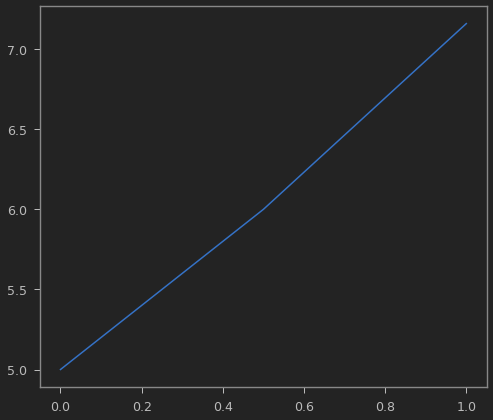

In [20]:
D_lst=[0,0.5,1]
ahat_lst=[5,6,7.16]
plt.plot(D_lst,ahat_lst)

In [21]:
# save_folder=None#'/home/AD/tttyree/bgmc_data'
# testing=True
# if testing:
#     fn_out=save_control_results_for_setting(a,D,
#                                     tavg_step=0.1,
#                                     tavg1_max=1,
#                                     tavg2_max=1,printing=True,save_folder=save_folder)
#     df=pd.read_csv(fn_out)
#     print(df.head())

In [22]:
D_lst=list(np.arange(0,3.1,0.2))
D_lst.append(0.7)
# D_lst=[0,0.3,0.7]
task_lst=[]
for a in [1.6,9.5]:
    for D in D_lst:#[4:]:
        task_lst.append((a,np.around(D,1)))
len(task_lst),len(task_lst)*15/60#hours if one worker is used... <2 hour if 4 workers are used
# task_lst

(34, 8.5)

In [23]:
np.random.seed(seed)
cp.random.seed(seed)

In [24]:
def routine(data):
    a,D=data
    return save_control_results_for_setting(a,D,Dt=1e-5,
                                    num_pairs=1500,
                                    tavg_step=2.,
                                    tavg1_max=20,
                                    tavg2_max=20,
                                    printing=False,
                                    save_folder='/home/AD/tttyree/bgmc_data')

In [25]:
len(task_lst)/4

8.5

In [26]:
start = time.time()
retval_lst=[]
for task in task_lst:
    retval_lst.append(routine(task))
print(f"the run time for {len(retval_lst)} simulations was {(time.time()-start)/60:.2f} minutes.")

/home/AD/tttyree/anaconda3/envs/pyenv_tt/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/AD/tttyree/anaconda3/envs/pyenv_tt/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


the run time for 34 simulations was 467.86 minutes.


In [27]:
# #apparent runtime=40min
# print(f"note: approximately 45 GB of RAM is needed per worker")
# npartitions=6#1#8
# print(f"running simulation on {npartitions} workers...")
# bag = db.from_sequence(task_lst, npartitions=npartitions).map(routine)
# start = time.time()
# retval_lst = list(bag)
# print(f"the run time for {len(retval_lst)} simulations was {(time.time()-start)/60:.2f} minutes.")
# # return retval_lst
# print(len(retval_lst))

# visualization

In [28]:
positions_out.shape

(5500, 4, 100)

In [29]:
a=5
D=1
positions_out, mean_array, std_array = gener_positions_control(
            a=a, D=D, printing=True,num_pairs=1000)

running simulation for 1000000 steps...
simulation 10% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 20% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 30% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 40% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 50% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 60% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 70% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 80% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 90% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 100% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation complete!
Total run time: 138.4179 seconds
the number of particles that didn't finished is 0 out of 100.
5500


In [30]:
tavg1=0
tavg2=0
printing=True
np.sqrt(2.6/0.6)
np.sqrt(5)

2.23606797749979

In [31]:
D

0

In [32]:
df = compute_attraction_coefficient_results(
    positions_out=positions_out, tavg1=0, tavg2=0, Dt=1e-5,printing=printing)
df.head()

,tavg1,tavg2,tmax,a,Delta_a,Rsq_a
0,0,0,0.005,7.139568,0.020423,0.998938
1,0,0,0.010,6.840775,0.011598,0.999254
2,0,0,0.015,6.067483,0.030449,0.990269
3,0,0,0.020,5.228016,0.037813,0.973513
4,0,0,0.025,4.576281,0.035718,0.961882


In [33]:
np.sqrt(5)

2.23606797749979

In [34]:
navg1=np.int(np.around(tavg1/(Dt*10**3)))
navg2=np.int(np.around(tavg2/(Dt*10**3)))

#define time points
#i=0
num_timepoints=positions_out.shape[0]
t_values=np.arange(0,Dt*num_timepoints,Dt)
#assert t_values.shape==range_values[:,i].shape

#moving avg
if tavg1>0:
    #compute the moving average of the positional trajectories
    tavg_values=moving_average(t_values,n=navg1)
    positions_out_ma=moving_average(positions_out, n=navg1)
else:
    tavg_values=t_values
    positions_out_ma=positions_out

#compute range # x1,y1,x2,y2
range_values= np.sqrt((positions_out_ma[:,0,:]-positions_out_ma[:,2,:])**2 + (positions_out_ma[:,1,:]-positions_out_ma[:,3,:])**2)



#compute savgol filter
if navg2>0:
    if navg2<30: navg2=30
    if navg2%2==0:navg2+=1
    #DONE: test whether there is a significant difference between the savgol derivative and the finite difference derivative of the savgol filter
    savgol_kwargs = dict(window_length=navg2,polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
    #compute the savgol_filtered values for R
    R_savgol_values=savgol_filter(range_values,**savgol_kwargs)
    SR_values=R_savgol_values**2
else:
    SR_values=range_values**2

#DONE: sompute MSR_values from SR_values
# SR_values

#     if printing:
#         print('nota bene: nan values are being kept in positions_out, so care needs to be taken to compute the particle averaged SR for every time')
#         print(f"HINT: I need to compute the nonnan boolean index for each time slice")
np.isnan(SR_values).any(),SR_values.shape
# assert not np.isnan(positions_out).any()

# the nonnan boolean index for each time slice
MSR_values=np.zeros_like(SR_values[:,0])
num_tbin,num_trials=SR_values.shape
for j in range (num_tbin):
    boo=~np.isnan(SR_values[j,:])
    MSR_values[j]=np.mean(SR_values[j,boo])

t_thresh_values=np.arange(0.005,0.04,0.005)

start=time.time()
#generate apparent attraction coefficient data
a_sr_lst=[]
Delta_a_sr_lst=[]
Rsq_sr_lst=[]
# a_one_over_R_lst=[]
# Delta_a_one_over_R_lst=[]
# Rsq_one_over_R_lst=[]
tdeath_values=np.max(tavg_values)-tavg_values
for t_thresh in t_thresh_values:
    #squared range method
    boo=tdeath_values<=t_thresh
    boo&=~np.isnan(MSR_values)
    if sum(boo)>2:
        dict_sr=compute_slope.compute_95CI_ols(tdeath_values[boo], MSR_values[boo])
        a_sr=dict_sr['m']/4
        Delta_a_sr=dict_sr['Delta_m']/4
        Rsquared=dict_sr['Rsquared']
    else:
        a_sr=np.nan
        Delta_a_sr=np.nan
        Rsquared=np.nan

#     #inverse range method
#     boo=one_over_R_values<1/R_thresh
#     dict_one_over_R=compute_slope.compute_95CI_ols(one_over_R_values[boo], dRdt_values[boo])
#     a_one_over_R=-1*dict_one_over_R['m']/2
#     Delta_a_one_over_R=dict_one_over_R['Delta_m']/2

    #record results
    a_sr_lst.append(a_sr)
    Delta_a_sr_lst.append(Delta_a_sr)
    Rsq_sr_lst.append(Rsquared)
#     a_one_over_R_lst.append(a_one_over_R)
#     Delta_a_one_over_R_lst.append(Delta_a_one_over_R)
#     Rsq_one_over_R_lst.append(dict_one_over_R['Rsquared'])
if printing:
    print(f"runtime computing attraction coefficients: {time.time()-start:.4f}")

df=pd.DataFrame({
    'tavg1':tavg1,
    'tavg2':tavg2,
    'tmax':t_thresh_values,
    'a':a_sr_lst,
    'Delta_a':Delta_a_sr_lst,
    'Rsq_a':Rsq_sr_lst
})
df

runtime computing attraction coefficients: 0.0749


,tavg1,tavg2,tmax,a,Delta_a,Rsq_a
0,0,0,0.005,7.139568,0.020423,0.998938
1,0,0,0.010,6.840775,0.011598,0.999254
2,0,0,0.015,6.067483,0.030449,0.990269
3,0,0,0.020,5.228016,0.037813,0.973513
4,0,0,0.025,4.576281,0.035718,0.961882
5,0,0,0.030,4.184043,0.029931,0.961586
6,0,0,0.035,3.819793,0.027175,0.955944
7,0,0,0.040,3.501530,0.025158,0.949003


In [140]:
navg1=np.int(np.around(tavg1/(Dt*10**3)))
navg2=np.int(np.around(tavg2/(Dt*10**3)))

#define time points
#i=0
num_timepoints=positions_out.shape[0]
t_values=np.arange(0,Dt*num_timepoints,Dt)
#assert t_values.shape==range_values[:,i].shape

#moving avg
if tavg1>0:
    #compute the moving average of the positional trajectories
    tavg_values=moving_average(t_values,n=navg1)
    positions_out_ma=moving_average(positions_out, n=navg1)
else:
    tavg_values=t_values
    positions_out_ma=positions_out

#compute range # x1,y1,x2,y2
range_values= np.sqrt((positions_out_ma[:,0,:]-positions_out_ma[:,2,:])**2 + (positions_out_ma[:,1,:]-positions_out_ma[:,3,:])**2)



#compute savgol filter
if navg2>0:
    if navg2<30: navg2=30
    if navg2%2==0:navg2+=1
    #DONE: test whether there is a significant difference between the savgol derivative and the finite difference derivative of the savgol filter
    savgol_kwargs = dict(window_length=navg2,polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
    #compute the savgol_filtered values for R
    R_savgol_values=savgol_filter(range_values,**savgol_kwargs)
    SR_values=R_savgol_values**2
else:
    SR_values=range_values**2

#DONE: sompute MSR_values from SR_values
# SR_values

#     if printing:
#         print('nota bene: nan values are being kept in positions_out, so care needs to be taken to compute the particle averaged SR for every time')
#         print(f"HINT: I need to compute the nonnan boolean index for each time slice")
np.isnan(SR_values).any(),SR_values.shape
# assert not np.isnan(positions_out).any()

# the nonnan boolean index for each time slice
MSR_values=np.zeros_like(SR_values[:,0])
num_tbin,num_trials=SR_values.shape
for j in range (num_tbin):
    boo=~np.isnan(SR_values[j,:])
    MSR_values[j]=np.mean(SR_values[j,boo])

t_thresh_values=np.arange(0.005,0.04,0.005)


In [141]:
start=time.time()
#generate apparent attraction coefficient data
a_sr_lst=[]
Delta_a_sr_lst=[]
Rsq_sr_lst=[]
# a_one_over_R_lst=[]
# Delta_a_one_over_R_lst=[]
# Rsq_one_over_R_lst=[]
tdeath_values=np.max(tavg_values)-tavg_values
for t_thresh in t_thresh_values:
    #squared range method
    boo=tdeath_values<=t_thresh
    boo&=~np.isnan(MSR_values)
    if sum(boo)>2:
        dict_sr=compute_slope.compute_95CI_ols(tdeath_values[boo], MSR_values[boo])
        a_sr=dict_sr['m']/4
        Delta_a_sr=dict_sr['Delta_m']/4
        Rsquared=dict_sr['Rsquared']
    else:
        a_sr=np.nan
        Delta_a_sr=np.nan
        Rsquared=np.nan

#     #inverse range method
#     boo=one_over_R_values<1/R_thresh
#     dict_one_over_R=compute_slope.compute_95CI_ols(one_over_R_values[boo], dRdt_values[boo])
#     a_one_over_R=-1*dict_one_over_R['m']/2
#     Delta_a_one_over_R=dict_one_over_R['Delta_m']/2

    #record results
    a_sr_lst.append(a_sr)
    Delta_a_sr_lst.append(Delta_a_sr)
    Rsq_sr_lst.append(Rsquared)
#     a_one_over_R_lst.append(a_one_over_R)
#     Delta_a_one_over_R_lst.append(Delta_a_one_over_R)
#     Rsq_one_over_R_lst.append(dict_one_over_R['Rsquared'])
if printing:
    print(f"runtime computing attraction coefficients: {time.time()-start:.4f}")

df=pd.DataFrame({
    'tavg1':tavg1,
    'tavg2':tavg2,
    'tmax':t_thresh_values,
    'a':a_sr_lst,
    'Delta_a':Delta_a_sr_lst,
    'Rsq_a':Rsq_sr_lst
})
df

runtime computing attraction coefficients: 0.0765


,tavg1,tavg2,tmax,a,Delta_a,Rsq_a
0,0,0,0.005,7.139568,0.020423,0.998938
1,0,0,0.010,6.840775,0.011598,0.999254
2,0,0,0.015,6.067483,0.030449,0.990269
3,0,0,0.020,5.228016,0.037813,0.973513
4,0,0,0.025,4.576281,0.035718,0.961882
5,0,0,0.030,4.184043,0.029931,0.961586
6,0,0,0.035,3.819793,0.027175,0.955944
7,0,0,0.040,3.501530,0.025158,0.949003


In [142]:
# the nonnan boolean index for each time slice
MSR_values=np.zeros_like(SR_values[:,0])
num_tbin,num_trials=SR_values.shape
for j in range (num_tbin):
    boo=~np.isnan(SR_values[j,:])
    MSR_values[j]=np.mean(SR_values[j,boo])

t_thresh_values=np.arange(0.005,0.04,0.005)


In [143]:
# start=time.time()
#generate apparent attraction coefficient data
a_sr_lst=[]
Delta_a_sr_lst=[]
Rsq_sr_lst=[]
# a_one_over_R_lst=[]
# Delta_a_one_over_R_lst=[]
# Rsq_one_over_R_lst=[]
tdeath_values=np.max(tavg_values)-tavg_values
for t_thresh in t_thresh_values:
    #squared range method
    boo=tdeath_values<=t_thresh
    boo&=~np.isnan(MSR_values)
    dict_sr=compute_slope.compute_95CI_ols(tdeath_values[boo], MSR_values[boo])
    a_sr=dict_sr['m']/4
    Delta_a_sr=dict_sr['Delta_m']/4
    
a_sr

3.501529675546694

In [144]:
SR_values

array([[       nan,        nan, 2.07751217, ...,        nan,        nan,
               nan],
       [       nan,        nan, 2.07320697, ...,        nan,        nan,
               nan],
       [       nan,        nan, 2.07337873, ...,        nan,        nan,
               nan],
       ...,
       [0.01293852, 0.01016335, 0.01189654, ..., 0.01128866, 0.01256878,
        0.01029097],
       [0.01176645, 0.01176738, 0.01093364, ..., 0.01016212, 0.01043423,
        0.01067259],
       [0.00976229, 0.00752802, 0.00952387, ..., 0.00956764, 0.00892987,
        0.00949838]])

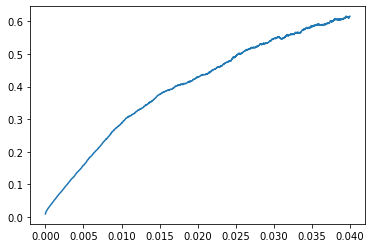

In [145]:
#squared range method
boo=tdeath_values<=t_thresh
boo&=~np.isnan(MSR_values)
plt.plot(tdeath_values[boo], MSR_values[boo])

In [146]:
lst=[]
for j in range(num_tbin):
    boo=~np.isnan(SR_values[j,:])
    lst.append(np.mean(SR_values[j,boo]))
MSR_values=np.array(list(lst))
MSR_values.shape

(5500,)

In [147]:
j=5
boo=~np.isnan(SR_values[j,:])
SR_values[j,:]
np.isnan(SR_values[j,~boo]).any()
np.isnan(SR_values[j]).any()

True

True

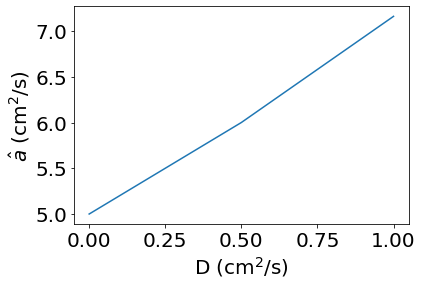

In [132]:
D_lst=[0,0.5,1]
ahat_lst=[5,6,7.16]
plt.plot(D_lst,ahat_lst)
format_plot(ax=plt.gca(),xlabel=r'D (cm$^2$/s)',ylabel=r'$\hat{a}$ (cm$^2$/s)')

In [ ]:
#TODO: measure slope of ^this

In [ ]:
#TODO: figure out why I keep getting stalling at zero!?

In [ ]:
# j=0
# boo=~np.isnan(SR_values[j,:])
# plt.hist(SR_values[j,boo])

In [ ]:
# t_values.shape,SR_values[::-1,:14].shape
1+1

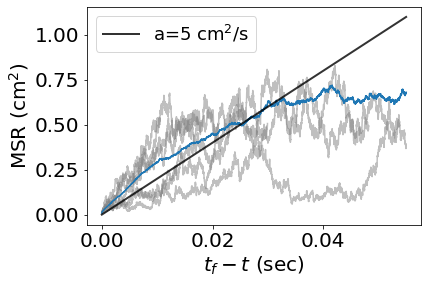

In [129]:
plt.plot(t_values,SR_values[::-1,:7],c='gray',alpha=0.5)
plt.plot(tdeath_values,MSR_values)
plt.plot(tdeath_values[1:],tdeath_values[1:]*4*a,c='k',lw=2,alpha=0.8,label=r'a=5 cm$^2$/s')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.legend(fontsize=18)
plt.show()

In [ ]:
i=6
print(range_values[::-1,i]**2)
plt.plot(t_values,range_values[::-1,i]**2,c='gray',lw=1,alpha=0.5)
plt.show()

In [ ]:
for i in range(7):#[5,7,100]:
    plt.plot(t_values,range_values[::-1,i]**2,c='gray',lw=1,alpha=0.5)
format_plot(ax=plt.gca(),xlabel='t (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

I think the problem was from when I was turning off a given particle's simulation.  If a particle stepped within the minimum distance, it had a chance to step out of that minimum distance and then be considered for another time step before being removed from the simulation.  Because of this, every particle had a nontrivial probability of "stalling" at the cutoff distance.  This "stalling" led to an attraction coefficient that was too small.  

After turning off particle motion at the end of each time step, [the simulation produced results in agreement with the case with no diffusion].

I produced a small proof supporting the independence of diffusion on the apparent attraction coefficient.  It is attached.

In [ ]:
MSR_values

In [ ]:
#make a simple plot of MSR vs tf-t
for i in [5,7,100,1000,50]:
    plt.plot(t_values,range_values[::-1,i]**2,c='gray',lw=1,alpha=0.5)
format_plot(ax=plt.gca(),xlabel='t (sec)',ylabel=r'MSR (cm$^2$)')
plt.plot(t_values[1:],MSR_values[1:]**2,c='C0',lw=2,alpha=0.5)
plt.plot(t_values[1:],t_values[1:]*4*5,c='k',lw=2,alpha=0.5,label='Expected')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.legend(fontsize=18)
plt.show()

#TODO: visualize a_SR versus tmax
#make a simple plot of MSR vs tf-t
for i in range(50):
    plt.plot(t_values,range_values[::-1,i]**2,c='gray',lw=1,alpha=0.05)
format_plot(ax=plt.gca(),xlabel='t (sec)',ylabel=r'MSR (cm$^2$)')
plt.plot(t_values[1:],MSR_values[1:]**2,c='C0',lw=2,alpha=0.5)
plt.plot(t_values[1:],t_values[1:]*4*5,c='k',lw=2,alpha=0.5,label='Expected')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.legend(fontsize=18)
plt.show()

#TODO: try to understand what the quadratic MSR versus t means

In [ ]:
#TODO: wrap map from tavg1,tavg2 to a_SR et al

In [ ]:
#TODO: dev grid search over tavg1,tavg2 to a dataframe of a_SR et al

In [ ]:
#TODO: save ^that dataframe as csv

In [ ]:
#(supposing the tavg1,tavg2 grid search is reasonably fast <1 hour),
#TODO: run a dask bag over D=0.,...,1. in min(0.1,x), where x = the minimum stepsize that should finish by the time I wakeup tomorrow
#nota bene: without too much difficulty, I could use 50 cores from ssh-miller and use ~5X smaller x...

In [ ]:
    #GOAL: vectorized processing
    # DONE: plot the basic results versus time and verify that they look reasonable
    # DONE(optional): compute the moving average of particle locations
    # DONE: compute all ranges
    # DONE: find the row index where the positions first become closer than R_thresh=0.001 cm

    #     ylabel_lst=['R (cm)','diffusive\nstep size (cm)','attractive\nstep size (cm)']
    #     fig,axs=plt.subplots(1,3,figsize=(14,4),constrained_layout=True)
    #     for i,(ax,ylabel) in enumerate(zip(axs,ylabel_lst)):
    #         ax.plot(mean_array[:,i])
    #         ax.fill_between(mean_array[:,i]-1.96*std_array[:,i],mean_array[:,i]+1.96*std_array[:,i],alpha=0.5)
    #         format_plot(ax=ax,xlabel='t (sec)',ylabel=ylabel)
    #     plt.show()
